## Data manipulation

In [12]:
import pandas as pd

In [13]:
import matplotlib.pyplot as plt
import numpy
import ipywidgets as widgets
from IPython.display import display

In [14]:
geo_df = pd.read_csv(r'data\geo.csv')
iccs_df = pd.read_csv(r'data\iccs.csv')

In [15]:
from dataclasses import dataclass

@dataclass
class Statistics:
    count_years: int = numpy.nan
    count_fill_values: int = numpy.nan
    first_fill_year: int = numpy.nan
    last_fill_year: int = numpy.nan
    mean_value: float = numpy.nan
    median_value: float = numpy.nan
    max_value: int = numpy.nan
    max_value_year: int = numpy.nan
    min_value: float = numpy.nan
    min_value_year: float = numpy.nan
    standard_deviation: float = numpy.nan
    quality_range_fill_data: int = numpy.nan
    quality_range_unfill_data: int = numpy.nan
    quality_data_info: str = numpy.nan
    min_range_year: int = numpy.nan
    max_range_year: int = numpy.nan # otázka zda používat, je to informace pro range widget
    statistics_dictionary: dict = None
    
    def get_statistics_dict_info(self):
        self.statistics_dictionary = {
            'count_years': self.count_years,
            'count_fill_values': self.count_fill_values,            
            'first_fill_year': self.first_fill_year,
            'last_fill_year': self.last_fill_year,
            'mean_value': self.mean_value,
            'median_value': self.median_value,
            'max_value': self.max_value,
            'max_value_year': self.max_value_year,
            'min_value': self.min_value,
            'min_value_year': self.min_value_year,
            'standard_deviation': self.standard_deviation,
            'quality_range_fill_data': self.quality_range_fill_data,
            'quality_range_unfill_data': self.quality_range_unfill_data,
            'quality_data_info': self.quality_data_info, 
            'min_range_year': self.min_range_year,
            'max_range_year': self.max_range_year
        }
        # return statistics_dictionary
        

    def get_quality_data(self, data = None, idx_first_fill_year = None, idx_last_fill_year = None):
        if self.count_fill_values == 0:
            self.quality_data_info = f'No record for crime.'

        elif self.count_fill_values == 1:
            self.quality_data_info = f'Only 1 record for crime.'
           
        else:
            count_fill_values_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['value'].count()
            count_fill_year_range = data[idx_first_fill_year:(idx_last_fill_year + 1)]['year'].count()
            self.quality_range_fill_data = count_fill_year_range
            self.quality_range_unfill_data = count_fill_year_range - count_fill_values_range

            if count_fill_values_range == count_fill_year_range:
                self.quality_data_info = 'The time series has no missing values within the data disclosure period.'
            else:
                number = count_fill_year_range - count_fill_values_range
                self.quality_data_info = f'The time series has {number} missing value(s) within the data disclosure period.'

            

    def calculate_from_data(self, data, code):
        if code != '1-1': # prozatimni ponechani, aby si clovek mohl filtroval tabulku, jak potrebuje
            self.quality_data_info = f'No statistics for this filtered data.'

        else:
            value_column = data['value']
            year_column = data['year']

            self.count_years = year_column.count()
            self.count_fill_values = value_column.count()

            if value_column.count() > 1:
                idx_first_fill_year = value_column.first_valid_index()
                self.first_fill_year = year_column[idx_first_fill_year]

                idx_last_fill_year = value_column.last_valid_index()
                self.last_fill_year = year_column[idx_last_fill_year]
               
                self.mean_value = round(value_column.mean(), 2)
                self.median_value = value_column.median()

                max_value_row = data.loc[data['value'].idxmax()]
                min_value_row = data.loc[data['value'].idxmin()]

                self.max_value, self.max_value_year = max_value_row[['value', 'year']]
                self.min_value, self.min_value_year = min_value_row[['value', 'year']]

                # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
                self.standard_deviation = round(numpy.std(value_column), 2)
                
                self.get_quality_data(data, idx_first_fill_year, idx_last_fill_year)
                self.get_statistics_dict_info()
                    

                # TODO: nutno pořešit v rámci změny filtrování, např. pokud budu mít všechny země, tento údaj úplně nědává smysl, 
                self.min_range_year = year_column.min() 
                self.max_range_year = year_column.max()

            elif value_column.count() == 1:
                self.min_value = data.loc[idx_first_fill_year, 'value']
                self.min_value_year = data.loc[idx_first_fill_year, 'year']
                self.get_quality_data(data)
                self.get_statistics_dict_info()
                
            else:
                self.get_quality_data(data)
                self.get_statistics_dict_info()


@dataclass
class EurostatCrimeTable:
    data: pd.DataFrame = None
    country_list_sorted: list = None
    crime_list_sorted: list = None
    country: str = None 
    crime: str = None
    filtered_data: pd.DataFrame = None
    filtered_code: None = None
    statistics: Statistics = None
    statistics_info: str = None

    
    def _get_sorted_list(self, unpivot_data):
        country_list_sorted = sorted(list(set(unpivot_data['country_name'].tolist())))
        country_list_sorted.insert(0, 'all')
        self.country_list_sorted = country_list_sorted

        crime_list_sorted = sorted(list(set(unpivot_data['crime_info'].tolist())))
        crime_list_sorted.insert(0, 'all')
        self.crime_list_sorted = crime_list_sorted


    def load_data(self, path=f'data/estat_crim_off_cat.tsv'):
        data = pd.read_csv(path, sep='\t')
        
        data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
        split_name_columns = (data.columns[0]).split(',')
        count_split_columns = len(split_name_columns)
        data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
        data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce

        data = data.merge(geo_df, how='left', on='geo')
        data = data.merge(iccs_df, how='left', on='iccs')
        data = data.drop(columns=['geo', 'iccs'])

        # presun rozdelenych a naparovaných udaju  na zacatek df
        reorg_columns = data.columns.tolist()
        final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
        data = data[final_reorg_columns]
        
        no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
        data = data.drop(index=no_anual)

        no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
        data = data.drop(index=no_p_hthab)

        years_list = data.columns[count_split_columns:]
        info_list = data.columns[:count_split_columns]

        unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
        unpivot_data['year'] = unpivot_data['year'].astype('int')
        unpivot_data['value'] = unpivot_data['value'].replace([': ', '0 ', '0.00 ', 0], numpy.nan).astype('float')
        
        self._get_sorted_list(unpivot_data)
        self.data = unpivot_data
        
    
    def filter_data(self, country, crime):
        self.country = country
        self.crime = crime
       

        # TODO: nahradit kody '1-1' novymi tridami, ktere budou dedit od Statistics()
        if country != 'all' and crime != 'all':
            filtered_data = self.data[(self.data['country_name'] == country) & (self.data['crime_info'] == crime)]
            filtered_data = filtered_data.sort_values(by='year', axis=0, ascending=True)
            # vznik noveho sloupce index!!
            self.filtered_data = filtered_data.reset_index()
            self.filtered_code = '1-1'
            # self.calc_func = self.statistics.calculate_from_data11 # fci ulozim jako parametr

        elif country != 'all' and crime == 'all':
            self.filtered_data = self.data[self.data['country_name'] == country]
            self.filtered_code = '1-all'
            
        elif country == 'all' and crime != 'all':
            self.filtered_data = self.data[self.data['crime_info'] == crime]
            self.filtered_code = 'all-1'

        elif country == 'all' and crime == 'all':
            self.filtered_data = self.data
            self.filtered_code = 'all-all'
        
        self.get_statistics()
        

    def get_statistics(self):
        # _calculate_statistics
        data = self.filtered_data
        code = self.filtered_code

        stat = Statistics()
        stat.calculate_from_data(data, code)
        # TODO zaktivnit calc_func
        # self.calc_func(data, code)
        self.statistics = stat

        if stat.last_fill_year != stat.max_range_year:
            info = f'Data disclosure by the country began in {stat.first_fill_year} and ended in {stat.last_fill_year}.'
        elif stat.last_fill_year == stat.max_range_year:
            info = f'Data disclosure by the country began in {stat.first_fill_year} and continues until {stat.max_range_year}.'
       
        
        if stat.count_fill_values in [0, 1]:
            self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime.'
        elif stat.count_fill_values not in [0, 1]:
            self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime. {info} Across these years, there were an average of {stat.mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {stat.standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {stat.min_value} in {stat.min_value_year}, while the maximum was {stat.max_value} in {stat.max_value_year}.'

        # TODO: vyřešit info o státu/kriminalitě
        # TODO: 
        # přidat dodatečné  informace o směrodané odchylce
        # přidat info o násobku z min -> max aj
        # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
        # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu
      
    def get_summarize_df_1all(self):
        dictionary_list = list()

        for country_name in self.country_list_sorted[1:]:
            for crime_name in self.crime_list_sorted[1:]:
               country_crime_dict = {'country': country_name, 'crime': crime_name}
               self.filter_data(country_name, crime_name)
               self.get_statistics()
               output_dictionary = self.statistics.statistics_dictionary
               country_crime_dict.update(output_dictionary)
               dictionary_list.append(country_crime_dict)
        country_crime_info_11 = pd.DataFrame.from_dict(dictionary_list)
        return country_crime_info_11
                

    def __str__(self):
        print(f'info {self.statistics}')


In [16]:
CrimeData = EurostatCrimeTable()
CrimeData.load_data()

In [17]:
# sum_info = CrimeData.get_summarize_df_1all()

In [18]:
# sum_info.head(30)
# a = sum_info[sum_info['count_fill_values'] == 'NaN']
# a


In [19]:
country = widgets.Dropdown(
    options=CrimeData.country_list_sorted,
    value=CrimeData.country_list_sorted[1],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=CrimeData.crime_list_sorted,
    value=CrimeData.crime_list_sorted[1],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', index=1, options=('all', 'Albania', 'Austria', 'Belgium', 'Bosnia and Herzego…

Dropdown(description='Crime:', index=1, options=('all', 'Acts against computer systems', 'Attempted intentiona…

In [20]:
select_country = country.value
select_crime = crime.value

In [21]:
select_crime
select_country

'Liechtenstein'

In [24]:
CrimeData.filter_data(select_country, select_crime)
# xys = CrimeData.filtered_data.replace([0], numpy.nan)
# xys

CrimeData.filtered_data#['value'].count()#.info()
#.replace([0, '0'], 'NaN')


,index,freq,unit,country_name,crime_info,year,value
0,137,A,P_HTHAB,Liechtenstein,Kidnapping,2008,NaN
1,911,A,P_HTHAB,Liechtenstein,Kidnapping,2009,NaN
2,1685,A,P_HTHAB,Liechtenstein,Kidnapping,2010,NaN
3,2459,A,P_HTHAB,Liechtenstein,Kidnapping,2011,NaN
4,3233,A,P_HTHAB,Liechtenstein,Kidnapping,2012,NaN
5,4007,A,P_HTHAB,Liechtenstein,Kidnapping,2013,NaN
6,4781,A,P_HTHAB,Liechtenstein,Kidnapping,2014,NaN
7,5555,A,P_HTHAB,Liechtenstein,Kidnapping,2015,NaN
8,6329,A,P_HTHAB,Liechtenstein,Kidnapping,2016,NaN
9,7103,A,P_HTHAB,Liechtenstein,Kidnapping,2017,NaN


In [25]:
CrimeData.statistics_info

'During a 15-year period, Liechtenstein recorded 0 entries for Kidnapping types of crime.'

In [26]:
CrimeData.statistics.quality_data_info

'No record for crime.'

## Data visualisation

In [38]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [39]:
years_range = widgets.IntRangeSlider(
    value=[CrimeData.statistics.min_range_year, CrimeData.statistics.max_range_year],
    min=CrimeData.statistics.min_range_year,
    max=CrimeData.statistics.max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

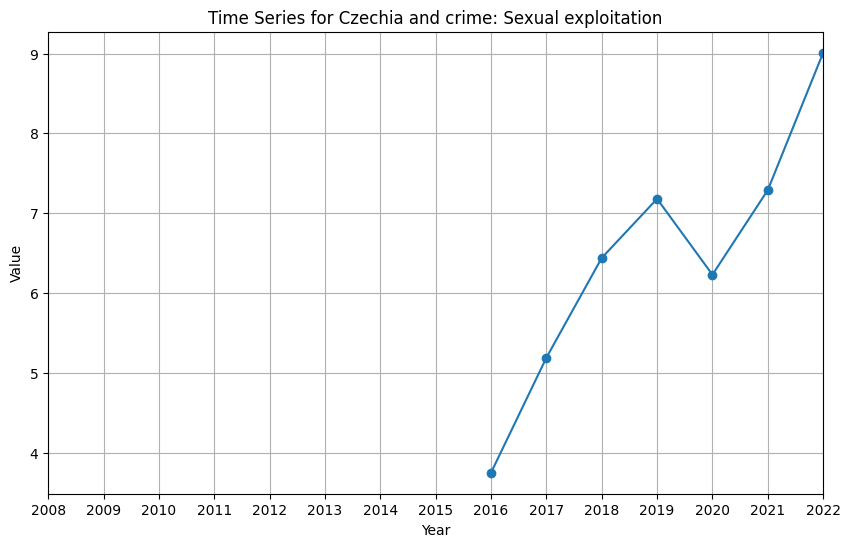

In [40]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(CrimeData.filtered_data['year'], CrimeData.filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

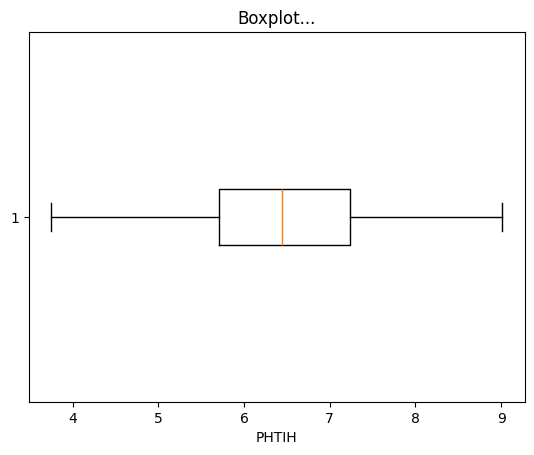

In [41]:
plt.boxplot(CrimeData.filtered_data['value'].dropna(), vert=False, showfliers=True)
plt.xlabel('PHTIH')
plt.title('Boxplot...')

# Show plot
plt.show()

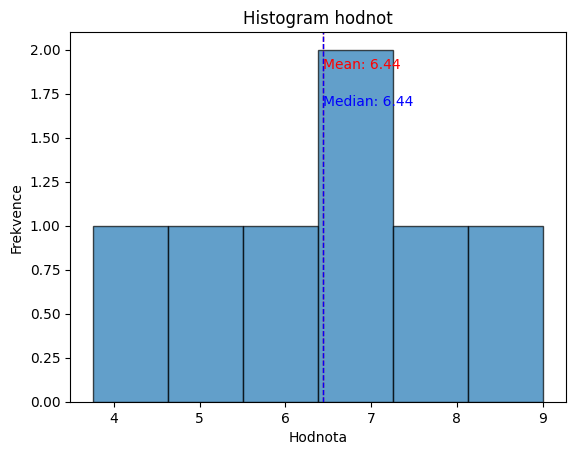

In [42]:
# import seaborn as sns
# sns.histplot(CrimeData.filtered_data['value'], bins=6, kde=True)
plt.hist(CrimeData.filtered_data['value'], bins=6, edgecolor='black', alpha=0.7)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')

# Mean line
plt.axvline(CrimeData.statistics.mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.mean_value, plt.ylim()[1]*0.9, f'Mean: {CrimeData.statistics.mean_value:.2f}', color = 'red')

# Median line
plt.axvline(CrimeData.statistics.median_value, color='blue', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.median_value, plt.ylim()[1]*0.8, f'Median: {CrimeData.statistics.median_value:.2f}', color='blue')



# Zobrazení grafu
plt.show()